In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://github.com/pbcquoc/crnn
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, min_length=6)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=2)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs)

Number of images found: 4333
Number of labels found: 4333
Number of unique characters: 2347
Characters present: {'㐌': 387, '浪': 356, '朱': 296, '\U000f070b': 292, '𠊛': 262, '\U000f047c': 260, '尼': 256, '娘': 252, '𦋦': 248, '𢚸': 246, '吏': 236, '固': 231, '拱': 220, '之': 199, '埃': 195, '情': 194, '𠳒': 179, '買': 178, '群': 175, '芇': 173, '𠓨': 157, '欺': 154, '別': 149, '麻': 148, '花': 147, '𠬠': 146, '𧗱': 144, '爫': 143, '仙': 142, '𡗶': 138, '𠄩': 132, '塘': 129, '如': 127, '𦖑': 126, '浽': 123, '𠫾': 122, '命': 122, '時': 121, '渚': 120, '渃': 118, '饒': 116, '呐': 115, '払': 115, '強': 114, '分': 114, '傷': 109, '𡢐': 108, '些': 108, '冲': 107, '鐄': 106, '𫽄': 106, '𢬣': 104, '低': 104, '生': 102, '皮': 100, '於': 100, '𧡊': 99, '仍': 99, '身': 98, '咍': 98, '茹': 97, '庒': 95, '牢': 94, '𣈜': 94, '昆': 93, '調': 92, '沛': 89, '\U000f061a': 89, '緣': 88, '細': 87, '公': 86, '月': 85, '油': 84, '﨤': 84, '戈': 84, '典': 84, '爲': 83, '排': 81, '畧': 80, '催': 78, '㗂': 77, '包': 76, '碎': 75, '𠁀': 75, '\U000f02c7': 74, '貝': 70, '賒': 70, '𢪀': 69, '共'

## Visualize the data

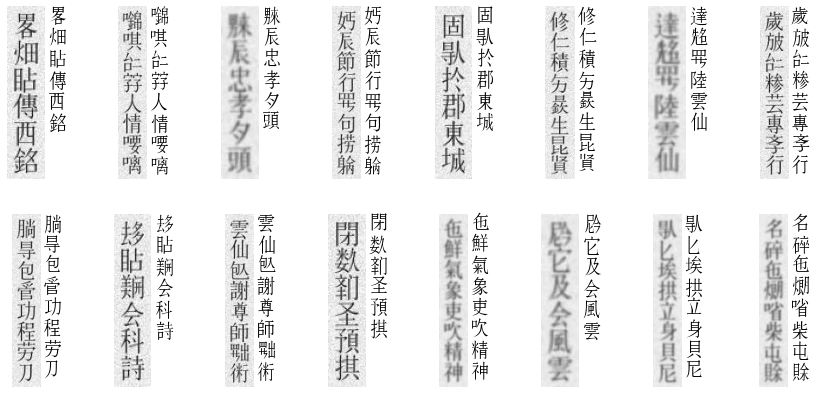

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = '[PAD]',
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = '[PAD]', 
    invert = True,
)

## Prepare `tf.data.Dataset` objects 

In [8]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num('[PAD]')
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

In [9]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [10]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Define the model

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Bidirectional, GRU,
    Lambda, RepeatVector, Permute, multiply
)
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [12]:
# https://pbcquoc.github.io/vietnamese-ocr (Vietnamese blog)
def visual_attention(feature_maps):
    _, timestep, input_dim = feature_maps.shape
    a = Permute((2, 1), name='dim_switching')(feature_maps)
    a = Dense(timestep, activation='softmax', name='attention_weights')(a)
    
    # Calculate the average of all timesteps and multiply by 100 to convert
    # the fraction obtained from the softmax calculation into a percentage
    a = Lambda(
        lambda x: tf.keras.backend.mean(x, axis=1) * 100, 
        name = 'average_weight'
    )(a)
    
    a = RepeatVector(input_dim, name='redistribute')(a)
    a = Permute((2, 1), name='attention_vector')(a) 
    return multiply([feature_maps, a], name='context_vector') 

In [13]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing output to RNN and apply attention mechanism
    x = reshape_for_cnn(x, dim_to_keep=-1)
    x = visual_attention(x)
    
    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.4,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [14]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [15]:
# imagenet_output_layer = 'block4_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

                                                                    'rnn_output[0][0]',             
                                                                    'label_length[0][0]']           
                                                                                                    
Total params: 15,843,424
Trainable params: 15,838,944
Non-trainable params: 4,480
____________________________________________________________________________________________________


# Training

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch < 1 or (epoch % 5) > 0: return lr # Keeps lr for each 5 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    min_lr = 1e-7, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [17]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [18]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
        model
    )

In [19]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/100
244/244 [==============================] - 19s 49ms/step - loss: 52.0261 - val_loss: 53.8465 - lr: 2.0000e-04
Epoch 2/100
244/244 [==============================] - 9s 36ms/step - loss: 46.8541 - val_loss: 49.2971 - lr: 2.0000e-04
Epoch 3/100
244/244 [==============================] - 8s 35ms/step - loss: 38.0174 - val_loss: 34.3141 - lr: 2.0000e-04
Epoch 4/100
244/244 [==============================] - 8s 34ms/step - loss: 22.6969 - val_loss: 20.0964 - lr: 2.0000e-04
Epoch 5/100
244/244 [==============================] - 8s 35ms/step - loss: 13.5221 - val_loss: 13.7125 - lr: 2.0000e-04
Epoch 6/100
244/244 [==============================] - 8s 35ms/step - loss: 8.3024 - val_loss: 10.0112 - lr: 2.0000e-04
Epoch 7/100
244/244 [==============================] - 8s 35ms/step - loss: 5.1992 - val_loss: 7.8454 - lr: 2.0000e-04
Epoch 8/100
244/244 [==============================] - 8s 35ms/step - loss: 3.2815 - val_loss: 5.7164 - lr: 

Epoch 38/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0241 - val_loss: 2.2870 - lr: 2.5000e-05
Epoch 39/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0232 - val_loss: 2.2843 - lr: 2.5000e-05
Epoch 40/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0223 - val_loss: 2.2777 - lr: 2.5000e-05
Epoch 41/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0215 - val_loss: 2.2842 - lr: 2.5000e-05
Epoch 42/100
243/244 [============================>.] - ETA: 0s - loss: 0.0207
Epoch 42: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
 - Mean edit distance: 1.3147322
244/244 [==============================] - 9s 35ms/step - loss: 0.0207 - val_loss: 2.2828 - lr: 2.5000e-05
Epoch 43/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0197 - val_loss: 2.2759 - lr: 1.2500e-05
Epoch 44/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0195 - val_loss: 2.2679 -

244/244 [==============================] - 9s 35ms/step - loss: 0.0796 - val_loss: 3.2358 - lr: 2.0000e-04
Epoch 21/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0678 - val_loss: 3.1046 - lr: 2.0000e-04
Epoch 22/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0574 - val_loss: 3.2138 - lr: 2.0000e-04
Epoch 23/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0499 - val_loss: 3.0868 - lr: 2.0000e-04
Epoch 24/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0430 - val_loss: 3.1637 - lr: 2.0000e-04
Epoch 25/100
243/244 [============================>.] - ETA: 0s - loss: 0.0375
Epoch 25: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.640625
244/244 [==============================] - 9s 35ms/step - loss: 0.0375 - val_loss: 3.1391 - lr: 2.0000e-04
Epoch 26/100
244/244 [==============================] - 8s 35ms/step - loss: 0.0336 - val_loss: 3.0581 - lr: 1.0000e-0

Epoch 8/100
244/244 [==============================] - 9s 37ms/step - loss: 3.6440 - val_loss: 5.8933 - lr: 2.0000e-04
Epoch 9/100
244/244 [==============================] - 9s 36ms/step - loss: 2.2973 - val_loss: 5.1731 - lr: 2.0000e-04
Epoch 10/100
244/244 [==============================] - 9s 36ms/step - loss: 1.4803 - val_loss: 4.2238 - lr: 2.0000e-04
Epoch 11/100
244/244 [==============================] - 9s 36ms/step - loss: 0.9855 - val_loss: 3.8391 - lr: 2.0000e-04
Epoch 12/100
244/244 [==============================] - 9s 36ms/step - loss: 0.6701 - val_loss: 3.3693 - lr: 2.0000e-04
Epoch 13/100
244/244 [==============================] - 9s 36ms/step - loss: 0.4539 - val_loss: 3.3799 - lr: 2.0000e-04
Epoch 14/100
244/244 [==============================] - 9s 36ms/step - loss: 0.3251 - val_loss: 2.9758 - lr: 2.0000e-04
Epoch 15/100
244/244 [==============================] - 9s 35ms/step - loss: 0.2416 - val_loss: 2.8285 - lr: 2.0000e-04
Epoch 16/100
244/244 [====================

Epoch 43/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0325 - val_loss: 2.2293 - lr: 7.8125e-07
Early stopping and restored the model weights from the end of epoch 38 - val_loss: 2.2074496746063232

============== Fold 04 training ==============
Epoch 1/100
244/244 [==============================] - 16s 49ms/step - loss: 52.1215 - val_loss: 53.4917 - lr: 2.0000e-04
Epoch 2/100
244/244 [==============================] - 9s 36ms/step - loss: 47.1226 - val_loss: 49.9928 - lr: 2.0000e-04
Epoch 3/100
244/244 [==============================] - 9s 37ms/step - loss: 38.9183 - val_loss: 34.0264 - lr: 2.0000e-04
Epoch 4/100
244/244 [==============================] - 9s 37ms/step - loss: 24.4634 - val_loss: 20.4223 - lr: 2.0000e-04
Epoch 5/100
244/244 [==============================] - 9s 36ms/step - loss: 15.2344 - val_loss: 14.0317 - lr: 2.0000e-04
Epoch 6/100
244/244 [==============================] - 9s 36ms/step - loss: 9.7051 - val_loss: 11.0302 - lr: 2.0000e-04
Epoc

Epoch 36/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0206 - val_loss: 2.6121 - lr: 2.5000e-05
Epoch 37/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0199 - val_loss: 2.6319 - lr: 2.5000e-05
Epoch 38/100
243/244 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 38: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
 - Mean edit distance: 1.53125
244/244 [==============================] - 9s 36ms/step - loss: 0.0195 - val_loss: 2.6411 - lr: 2.5000e-05
Epoch 39/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0189 - val_loss: 2.6371 - lr: 1.2500e-05
Epoch 40/100
243/244 [============================>.] - ETA: 0s - loss: 0.0185
Epoch 40: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.5401785
244/244 [==============================] - 9s 36ms/step - loss: 0.0185 - val_loss: 2.6454 - lr: 1.2500e-05
Epoch 41/100
244/244 [=============================

Epoch 31/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0544 - val_loss: 2.2182 - lr: 1.0000e-04
Epoch 32/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0452 - val_loss: 2.1845 - lr: 1.0000e-04
Epoch 33/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0385 - val_loss: 2.2169 - lr: 1.0000e-04
Epoch 34/100
243/244 [============================>.] - ETA: 0s - loss: 0.0348
Epoch 34: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.3258928
244/244 [==============================] - 9s 36ms/step - loss: 0.0348 - val_loss: 2.1915 - lr: 1.0000e-04
Epoch 35/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0306 - val_loss: 2.1499 - lr: 5.0000e-05
Epoch 36/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0284 - val_loss: 2.1489 - lr: 5.0000e-05
Epoch 37/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0264 - val_loss: 2.1317 -

Epoch 11/100
244/244 [==============================] - 9s 36ms/step - loss: 1.1215 - val_loss: 4.0343 - lr: 2.0000e-04
Epoch 12/100
244/244 [==============================] - 9s 36ms/step - loss: 0.7498 - val_loss: 3.6848 - lr: 2.0000e-04
Epoch 13/100
244/244 [==============================] - 9s 36ms/step - loss: 0.5135 - val_loss: 3.3968 - lr: 2.0000e-04
Epoch 14/100
244/244 [==============================] - 9s 35ms/step - loss: 0.3626 - val_loss: 3.1903 - lr: 2.0000e-04
Epoch 15/100
244/244 [==============================] - 9s 36ms/step - loss: 0.2637 - val_loss: 2.9618 - lr: 2.0000e-04
Epoch 16/100
244/244 [==============================] - 9s 36ms/step - loss: 0.2026 - val_loss: 2.8358 - lr: 2.0000e-04
Epoch 17/100
244/244 [==============================] - 9s 35ms/step - loss: 0.1566 - val_loss: 2.7901 - lr: 2.0000e-04
Epoch 18/100
244/244 [==============================] - 9s 36ms/step - loss: 0.1302 - val_loss: 2.7379 - lr: 2.0000e-04
Epoch 19/100
244/244 [==================

244/244 [==============================] - 9s 36ms/step - loss: 0.0173 - val_loss: 2.3509 - lr: 1.5625e-06
Early stopping and restored the model weights from the end of epoch 41 - val_loss: 2.3338189125061035

============== Fold 07 training ==============
Epoch 1/100
244/244 [==============================] - 16s 46ms/step - loss: 52.1052 - val_loss: 52.9574 - lr: 2.0000e-04
Epoch 2/100
244/244 [==============================] - 9s 39ms/step - loss: 46.9530 - val_loss: 48.4381 - lr: 2.0000e-04
Epoch 3/100
244/244 [==============================] - 9s 37ms/step - loss: 38.6344 - val_loss: 34.1124 - lr: 2.0000e-04
Epoch 4/100
244/244 [==============================] - 9s 38ms/step - loss: 23.6156 - val_loss: 21.1376 - lr: 2.0000e-04
Epoch 5/100
244/244 [==============================] - 9s 37ms/step - loss: 14.4291 - val_loss: 14.8499 - lr: 2.0000e-04
Epoch 6/100
244/244 [==============================] - 9s 37ms/step - loss: 8.9937 - val_loss: 10.4849 - lr: 2.0000e-04
Epoch 7/100
244/2

Epoch 37/100
243/244 [============================>.] - ETA: 0s - loss: 0.0212
Epoch 37: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.4375
244/244 [==============================] - 9s 35ms/step - loss: 0.0212 - val_loss: 2.6457 - lr: 1.0000e-04
Epoch 38/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0195 - val_loss: 2.6291 - lr: 5.0000e-05
Epoch 39/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0188 - val_loss: 2.6126 - lr: 5.0000e-05
Epoch 40/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0176 - val_loss: 2.6218 - lr: 5.0000e-05
Epoch 41/100
243/244 [============================>.] - ETA: 0s - loss: 0.0174
Epoch 41: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.4330357
244/244 [==============================] - 9s 35ms/step - loss: 0.0174 - val_loss: 2.6207 - lr: 5.0000e-05
Epoch 42/100
244/244 [=============================

Epoch 29/100
244/244 [==============================] - 9s 36ms/step - loss: 0.1545 - val_loss: 2.6545 - lr: 1.0000e-04
Epoch 30/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0807 - val_loss: 2.6202 - lr: 1.0000e-04
Epoch 31/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0608 - val_loss: 2.5955 - lr: 1.0000e-04
Epoch 32/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0504 - val_loss: 2.5899 - lr: 1.0000e-04
Epoch 33/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0422 - val_loss: 2.6214 - lr: 1.0000e-04
Epoch 34/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0374 - val_loss: 2.5588 - lr: 1.0000e-04
Epoch 35/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0331 - val_loss: 2.5405 - lr: 1.0000e-04
Epoch 36/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0295 - val_loss: 2.5398 - lr: 1.0000e-04
Epoch 37/100
244/244 [==================

244/244 [==============================] - 9s 37ms/step - loss: 0.0080 - val_loss: 2.4279 - lr: 6.2500e-06
Epoch 66/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0079 - val_loss: 2.4257 - lr: 6.2500e-06
Epoch 67/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0079 - val_loss: 2.4340 - lr: 6.2500e-06
Epoch 68/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0078 - val_loss: 2.4169 - lr: 6.2500e-06
Epoch 69/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0077 - val_loss: 2.4219 - lr: 6.2500e-06
Epoch 70/100
244/244 [==============================] - ETA: 0s - loss: 0.0076
Epoch 70: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
 - Mean edit distance: 1.3191965
244/244 [==============================] - 12s 50ms/step - loss: 0.0076 - val_loss: 2.4217 - lr: 6.2500e-06
Epoch 71/100
244/244 [==============================] - 10s 41ms/step - loss: 0.0075 - val_loss: 2.4302 - lr: 3.1250e

Epoch 28/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0286 - val_loss: 2.6983 - lr: 1.0000e-04
Epoch 29/100
244/244 [==============================] - 9s 38ms/step - loss: 0.0266 - val_loss: 2.6591 - lr: 1.0000e-04
Epoch 30/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0246 - val_loss: 2.6991 - lr: 1.0000e-04
Epoch 31/100
243/244 [============================>.] - ETA: 0s - loss: 0.0228
Epoch 31: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.4352678
244/244 [==============================] - 9s 36ms/step - loss: 0.0228 - val_loss: 2.7201 - lr: 1.0000e-04
Epoch 32/100
244/244 [==============================] - 9s 37ms/step - loss: 0.0213 - val_loss: 2.6414 - lr: 5.0000e-05
Epoch 33/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0204 - val_loss: 2.6411 - lr: 5.0000e-05
Epoch 34/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0194 - val_loss: 2.6247 -

Epoch 10/100
244/244 [==============================] - 9s 36ms/step - loss: 1.2360 - val_loss: 4.7315 - lr: 2.0000e-04
Epoch 11/100
244/244 [==============================] - 9s 37ms/step - loss: 0.7945 - val_loss: 4.3454 - lr: 2.0000e-04
Epoch 12/100
244/244 [==============================] - 10s 43ms/step - loss: 0.5220 - val_loss: 3.8921 - lr: 2.0000e-04
Epoch 13/100
244/244 [==============================] - 9s 39ms/step - loss: 0.3639 - val_loss: 3.5570 - lr: 2.0000e-04
Epoch 14/100
244/244 [==============================] - 9s 38ms/step - loss: 0.2674 - val_loss: 3.3936 - lr: 2.0000e-04
Epoch 15/100
244/244 [==============================] - 9s 39ms/step - loss: 0.1994 - val_loss: 3.1823 - lr: 2.0000e-04
Epoch 16/100
244/244 [==============================] - 9s 37ms/step - loss: 0.1562 - val_loss: 3.0415 - lr: 2.0000e-04
Epoch 17/100
244/244 [==============================] - 9s 37ms/step - loss: 0.1235 - val_loss: 3.0515 - lr: 2.0000e-04
Epoch 18/100
244/244 [=================

## Get the best CRNN model and its results

In [20]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_fold_epoch,
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 1.3258928060531616
28/28 [==============================] - 0s 15ms/step - loss: 2.2675
Fold 02 - Mean edit distance: 1.5758928060531616
28/28 [==============================] - 0s 15ms/step - loss: 2.9332
Fold 03 - Mean edit distance: 1.46875
28/28 [==============================] - 0s 16ms/step - loss: 2.2074
Fold 04 - Mean edit distance: 1.53125
28/28 [==============================] - 0s 15ms/step - loss: 2.6121
Fold 05 - Mean edit distance: 1.2433035373687744
28/28 [==============================] - 0s 15ms/step - loss: 2.0683
Fold 06 - Mean edit distance: 1.4464285373687744
28/28 [==============================] - 1s 17ms/step - loss: 2.3338
Fold 07 - Mean edit distance: 1.4263392686843872
28/28 [==============================] - 0s 15ms/step - loss: 2.6126
Fold 08 - Mean edit distance: 1.3303571939468384
28/28 [==============================] - 0s 15ms/step - loss: 2.4169
Fold 09 - Mean edit distance: 1.3973214626312256
28/28 [======================

Fold 05 has the best result at epoch 51:
- Loss on validation: 2.0682623386383057
- Mean edit distance: 1.2433035373687744


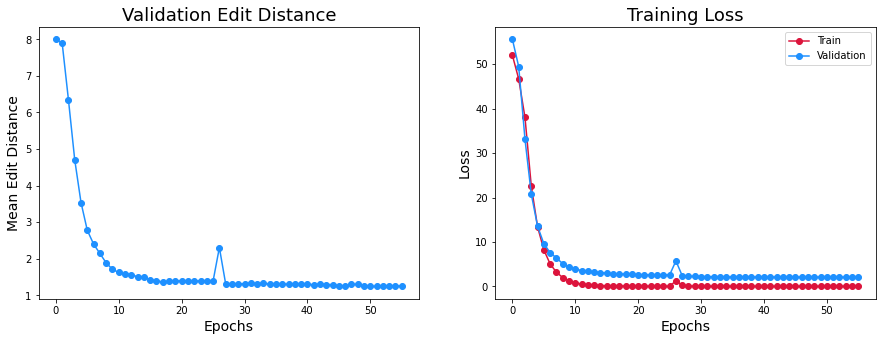

In [21]:
print(f'Fold {best_fold_idx + 1:02d} has the best result at epoch {best_fold_epoch + 1}:')
print(f'- Loss on validation: {best_loss}')
print(f'- Mean edit distance: {best_edist_log[best_fold_epoch]}')
plot_training_results(best_history, best_edist_log, 'JustFeaturesInput.png')
best_model.save('JustFeaturesInput.h5')

# Inference

In [22]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

## Reload the model

In [23]:
reloaded_model = load_model('JustFeaturesInput.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_5"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

                                                                    'label_length[0][0]',           
                                                                    'rnn_output[0][0]']             
                                                                                                    
Total params: 15,843,424
Trainable params: 15,838,944
Non-trainable params: 4,480
____________________________________________________________________________________________________


## On test dataset

Batch 1: ['吹柴傷伵㤕車𥪝𢚸', '𡢐昆拱𤎜𭛣𠁀', '呂\U000f047c柴沛𣴓唎爫之', '嫌爲馭唉群賖', '朗名昆討匪願碎𬆄', '為匕淡娄裊塘群賖', '悲徐都𠖈本鄕', '𠲖欺𪽗虎不成', '閨卿分妬役之細低', '差軍\U000f0761幅书𧗱', '\U000f0152它𤑟鄧源干', '𦖻𦖑㗂呐請台', '𦖻𦖑𢈱呐𢬣連𢭂簪', '塘賖審匕興𢙇', '塘賖審匕淡𨱽潙匕', '矯公䀡𧡊𢚸強生𪟽']

Batch 2: ['故牢𢧚浽昆𠫾𠬠𠇮', '月娥胣唉嵬匕', '後塘昆呵暫𨆢', '月娥汝細㤕𢚷分𠇮', '悶分苦辨悶淫苦沛', '𡀯払吀呐自頭劄𦋦', '𨑗棱𧯶易𠬠核', '云仙群唉囬鄕咏茄', '昆它𢧚𡦂䘮蓬\U000f0803庒', '歲𣃣𠄩𬙞容顔𠼦麻', '云仙暫住𠬠囬𢭂书', '武公䀡𧡊信书', '呵𠸦户陸福䝨生昆', '仙浪𢘾量岳爺', '悶朱直𤯭\U000f0803仙', '直浪嗔讓仙\U000f0268爫英']

Batch 3: ['𫢩它結\U000f0482弟兄', '彩鵉荘點𦋦尼梨庭', '䏾𦝄𣃣格梗橷', '塘賖𠦳淡嗔迻𠬠𢈱', '払油﨤𣅶顯荣', '唉吀朱汝𡀯卢買神', '調𠓨𠬠舘盃唭語迎', '志皮固志嵬皮空嵬', '姅分吏咭姅分吏傷', '哙𦋦買別母慈𧗱圭', '舘浪𡗶坦清明', '自低朱細圭茄群𥹰', '﨤柴爫茦𠸜浪趙昂', '童浪钱泊庒饒', '𡢐䀡医斈次求東医', '六君四物湯名']



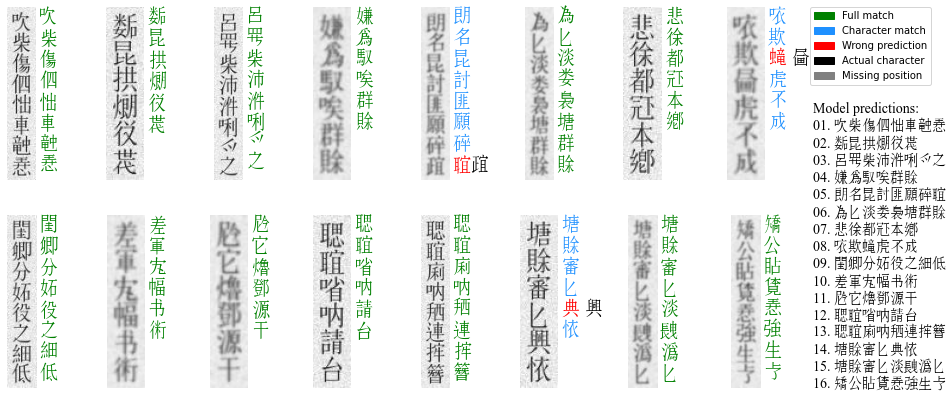

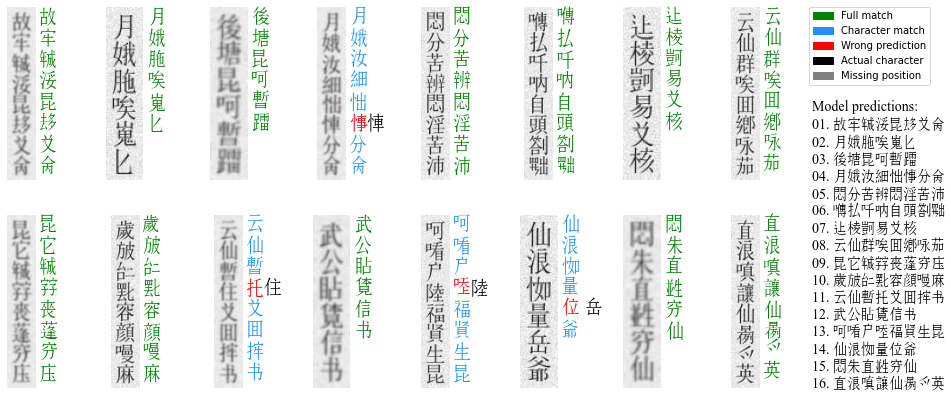

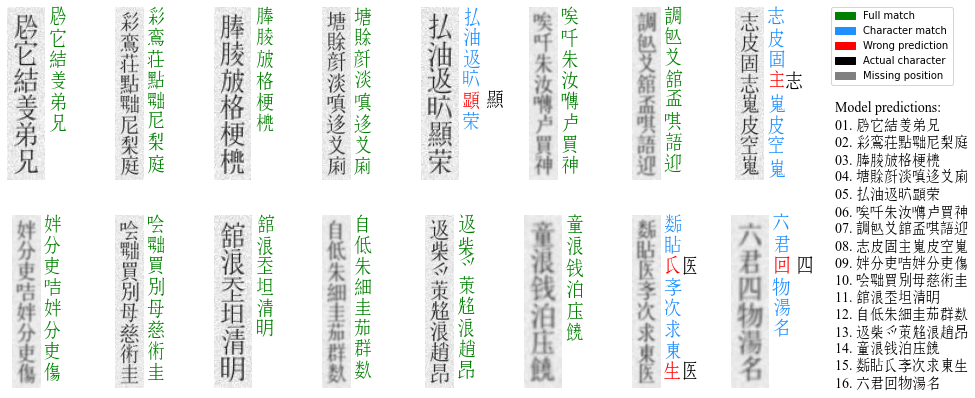

In [24]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [25]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史記全書


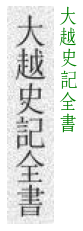

In [26]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))